# Simulation of noisy quantum circuits on Amazon Braket with PennyLane

In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

In this tutorial, we will explore the impact of noise on quantum hybrid algorithms. 
In previous tutorials, we have seen two examples of quantum hybrid algorithms, 
[the variational quantum eigensolver (VQE)](../3_Hydrogen_Molecule_geometry_with_VQE/3_Hydrogen_Molecule_geometry_with_VQE.ipynb) 
and 
[the quantum approximate optimization algorithm (QAOA)](../2_Graph_optimization_with_QAOA/2_Graph_optimization_with_QAOA.ipynb), 
applied to quantum chemistry and graph-based optimization problems respectively in noiseless settings. 
These algorithms are promising for the near term noisy quantum devices, and we will take QAOA as an example to benchmark its performance in the presence of noise.

Additionally, the tutorial gives an overview of noise simulation on Amazon Braket with PennyLane, such that the user will be able to use PennyLane to simulate the noisy circuits, on either the local or Braket on-demand noise simulator. In particular, the notebook covers the basic concepts of noise channels (for more details, see [here](../../../quantum_sims/noise_simulations/Simulating_Noise_On_Amazon_Braket.ipynb)) and uses PennyLane to compute cost functions of noisy circuits and optimize them. 

## Table of contents:
* [Import of necessary packages](#import)
* [Simulation of a noisy circuit](#simulation)
    * [Simulation of noisy circuits with built-in noise channels](#builtin)
    * [Simulation of noisy circuits with custom noise channels](#custom)    

* [Impact of noise on graph optimization with QAOA](#noise_qaoa)
    * [Defining a noisy QAOA circuit](#define_circuit)
    * [Benchmarking a noisy circuit evaluation](#benchmark1_v2)
    * [Comparing the effect of noise channels for QAOA](#benchmark2_v2)

## Import of necessary packages <a class="anchor" id="import"></a>

Before we get started, let us import the packages that we will use throughout this tutorial.

In [2]:
import pennylane as qml
from pennylane import numpy as np

import time
from collections import Counter

import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import unitary_group

## Simulation of a noisy circuit <a class="anchor" id="simulation"></a>

In today's Noisy Intermediate-Scale Quantum (NISQ) era, quantum computers do not perform perfect computations. Instead, every time a gate is executed or a qubit waits during the computation, there is a small chance that an error will occur.
To understand how quantum algorithms behave when executed on today's devices, it is therefore important to take noise into account, and quantum simulators are powerful tools to study the impact of noise on the performance of near-term algorithms.

A convenient and universal way of modeling noise in a quantum circuit is via Kraus operators. Letting the initial state be represented by the density matrix $\rho$, the output of the noisy quantum circuit (or quantum channel) $\Phi$ is represented by 

$
\Phi(\rho) = \sum_iK_i\rho K_i^\dagger
$

where the operators $\left\{K_i\right\}$, called Kraus operators, satisfy $\sum_i K_i^\dagger K_i = \mathbb{1}$ (notice the adjoint comes first), where $\mathbb{1}$ is the identity operator. PennyLane provides the following pre-defined single qubit noise channels:

* [BitFlip](https://pennylane.readthedocs.io/en/latest/code/api/pennylane.BitFlip.html)
* [PhaseFlip](https://pennylane.readthedocs.io/en/latest/code/api/pennylane.PhaseFlip.html)
* [DepolarizingChannel](https://pennylane.readthedocs.io/en/latest/code/api/pennylane.DepolarizingChannel.html)
* [AmplitudeDamping](https://pennylane.readthedocs.io/en/latest/code/api/pennylane.AmplitudeDamping.html)
* [GeneralizedAmplitudeDamping](https://pennylane.readthedocs.io/en/latest/code/api/pennylane.GeneralizedAmplitudeDamping.html)
* [PhaseDamping](https://pennylane.readthedocs.io/en/latest/code/api/pennylane.PhaseDamping.html)

In this section, we will illustrate how to simulate noisy quantum circuits with PennyLane's built-in noise channels, followed by how to define custom noise channels. 

### Simulation of noisy circuits with built-in noise channels<a class="anchor" id="builtin"></a>

First, we consider a quantum circuit for preparing the `n`-qubit GHZ state. For an illustration of the circuit, see [this notebook](../../../../Getting_Started/1_Running_quantum_circuits_on_simulators/1_Running_quantum_circuits_on_simulators.ipynb). When building this quantum circuit, we assume that all unitary gates are subject to the same single qubit noise, with the same probability. For the purpose of comparing different noise channels, we wrap the quantum circuit into a function as below.

In [3]:
def ghz_circuits(noise_opt, wires):
    """
    Function to return simple GHZ circuit ansatz, subject to a given noise operator. 
    The output is a method for specifying the number of qubits and the noise strength of the GHZ circuit.
    The result type is `Probability`. 
    """

    def circuits(p):
        """
        The noisy quantum circuit with noise strength p
        """
        qml.Hadamard(wires=0)
        noise_opt(p, wires=0)
        for i in range(0, wires - 1):
            qml.CNOT(wires=[i, i + 1])
            noise_opt(p, wires=i)
            noise_opt(p, wires=i + 1)
        return qml.probs(wires=range(0, wires))

    return circuits

As an example, we look at two GHZ circuits, each with `n=6` qubits, subject to bit flip and depolarizing noise, respectively. The circuits are constructed for various noise strengths, with the output being the corresponding probability distributions.

In [4]:
wires = 6

noise_opt_1 = qml.BitFlip
noise_opt_2 = qml.DepolarizingChannel
# noise_opt_2 = qml.PhaseDamping

dev = qml.device("braket.local.qubit", backend="braket_dm", wires=wires)
ghz_1 = qml.QNode(ghz_circuits(noise_opt_1, wires), dev)
ghz_2 = qml.QNode(ghz_circuits(noise_opt_2, wires), dev)


# Draw the quantum circuits
ghz_1_drawer = qml.draw(ghz_1)
ghz_2_drawer = qml.draw(ghz_2)
print("The circuit for ghz with BitFlip is\n", ghz_1_drawer(0.0))
print("The circuit for ghz with Depolarizing is\n", ghz_2_drawer(0.0))

The circuit for ghz with BitFlip is
 0: ──H──BitFlip(0.00)─╭●──BitFlip(0.00)─────────────────────────────────────────────────────────
1: ───────────────────╰X──BitFlip(0.00)─╭●──BitFlip(0.00)───────────────────────────────────────
2: ─────────────────────────────────────╰X──BitFlip(0.00)─╭●──BitFlip(0.00)─────────────────────
3: ───────────────────────────────────────────────────────╰X──BitFlip(0.00)─╭●──BitFlip(0.00)───
4: ─────────────────────────────────────────────────────────────────────────╰X──BitFlip(0.00)─╭●
5: ───────────────────────────────────────────────────────────────────────────────────────────╰X

─────────────────┤ ╭Probs
─────────────────┤ ├Probs
─────────────────┤ ├Probs
─────────────────┤ ├Probs
───BitFlip(0.00)─┤ ├Probs
───BitFlip(0.00)─┤ ╰Probs
The circuit for ghz with Depolarizing is
 0: ──H──DepolarizingChannel(0.00)─╭●──DepolarizingChannel(0.00)─────────────────────────────────
1: ───────────────────────────────╰X──DepolarizingChannel(0.00)─╭●──DepolarizingChann

Finally, we collect and present the results as histograms. For noise-free circuits with $p=0$, there are only two peaks corresponding to states where all qubits take values of 0 or 1 respectively, and their values sum to 1. As the noise probability gets larger, the sum of the leftmost and rightmost probabilities in the histogram gets smaller, as expected.

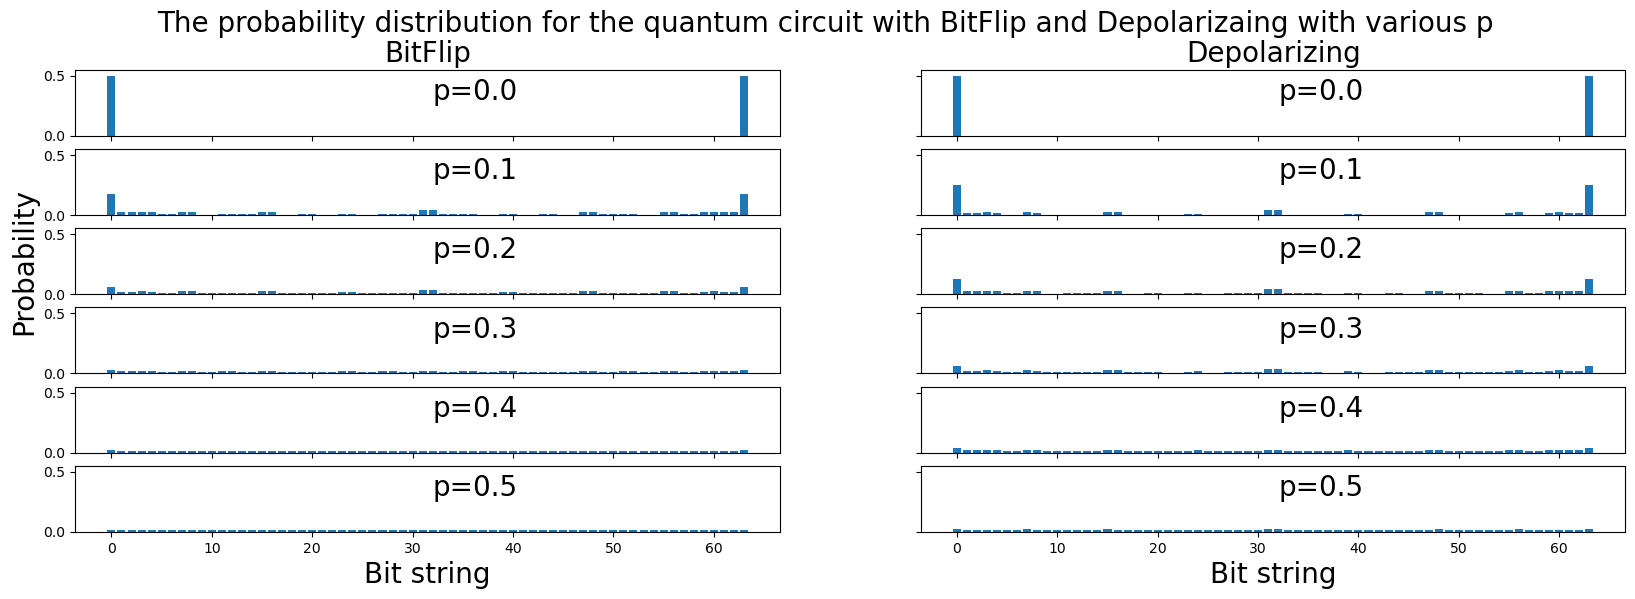

In [5]:
# Obtain the results for different noise strengths
ps = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
res_1 = []
res_2 = []

for p in ps:
    res_1.append(ghz_1(p))
    res_2.append(ghz_2(p))


fig, axs = plt.subplots(len(ps), 2, figsize=(20, 6))

plt.suptitle(
    "The probability distribution for the quantum circuit with BitFlip and Depolarizaing with various p",
    size=20,
)

axs[0][0].set_title("BitFlip", size=20)
axs[0][1].set_title("Depolarizing", size=20)
# axs.set_ylabel('Probability')
for ii in range(len(ps)):
    axs[ii][0].bar(range(2 ** wires), res_1[ii])
    axs[ii][1].bar(range(2 ** wires), res_2[ii])
    axs[ii][0].set_ylim([0, 0.55])
    axs[ii][1].set_ylim([0, 0.55])
    textstr = "".join(("p=", str(ps[ii])))
    axs[ii][0].text(2 ** wires / 2, 0.3, textstr, fontsize=20)
    axs[ii][1].text(2 ** wires / 2, 0.3, textstr, fontsize=20)
axs[2][0].set_ylabel("Probability", size=20)
for ax in axs.flat:
    ax.set_xlabel("Bit string", size=20)
for ax in axs.flat:
    ax.label_outer()
    
plt.show()

### Simulation of noisy circuits with custom noise channels<a class="anchor" id="custom"></a>
PennyLane offers a way for users to define their own noise channels with `QubitChannel` by specifying the Kraus operators of the channel. We illustrate this feature with a Kraus channel with randomly generated unitary matrices

$
K_0 = \sqrt{1-p}\mathbb{1}, \quad K_i = \sqrt{\frac{p}{3}}U_i
$

where $p\in[0,1]$ is the noise strength, and $U_i^\dagger U_i=\mathbb{1}\ (i=1,2,3)$ are random unitary matrices. We define a quantum circuit for generating an `n`-qubit GHZ state, subject to this custom noise channel. Again, we assume that all unitary gates are subject to the same noise channel, with the same probability.

In [6]:
def ghz_circuits_custom_noise(wires, Ks):
    """
    Function to return simple GHZ circuit ansatz with customized noise channel. 
    The result type is `Probability`.     
    """
    qml.Hadamard(wires=0)
    qml.QubitChannel(Ks, wires=0)

    for i in range(0, wires - 1):
        qml.CNOT(wires=[i, i + 1])
        qml.QubitChannel(Ks, wires=i)
        qml.QubitChannel(Ks, wires=i + 1)

    return qml.probs(wires=range(0, wires))

<div class="alert alert-block alert-info">
<b>Note</b> The maximum number of Kraus operators allowed for a custom noise channel is four.
</div>

We initialize the random matrices $U_i$, then define the custom noise channel with various noise strength p. Again, we take the 6-qubit GHZ state as an example. 

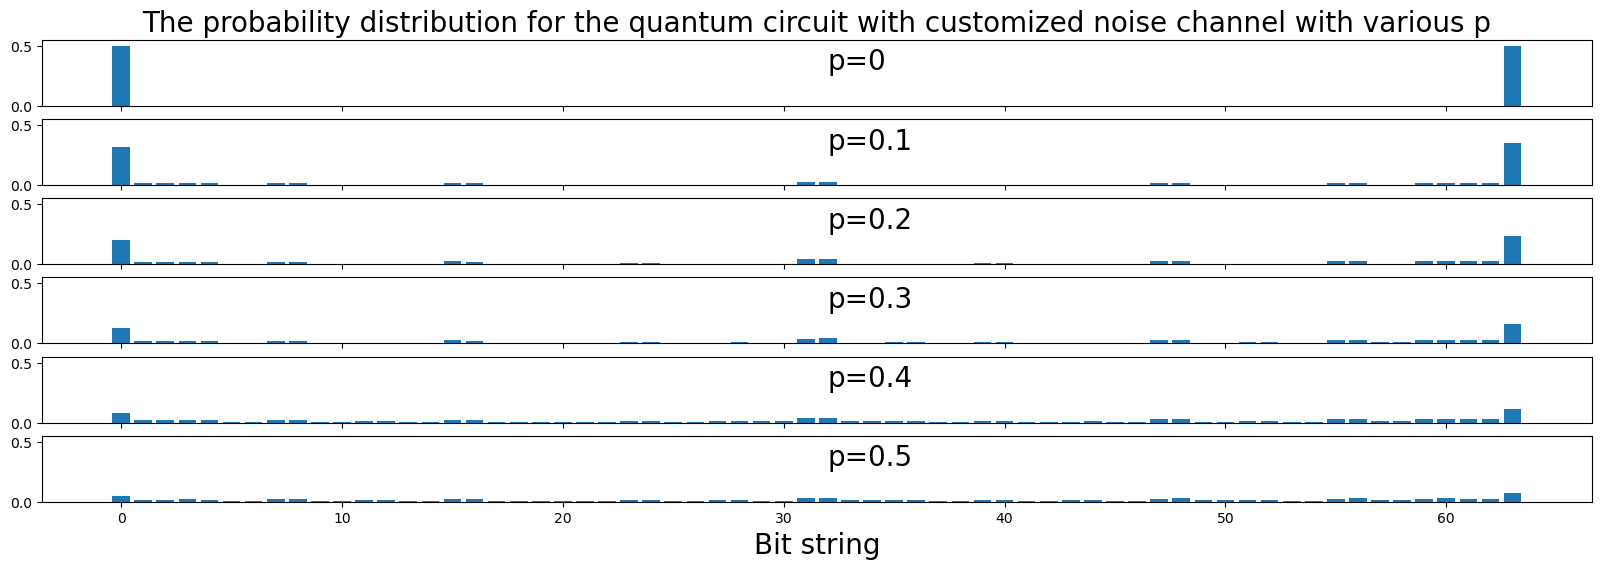

In [7]:
wires = 6
dev = qml.device("braket.local.qubit", backend="braket_dm", wires=wires)
ghz = qml.QNode(ghz_circuits_custom_noise, dev)
ghz_drawer = qml.draw(ghz)

ps = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

Ks_basis = [np.eye(2), unitary_group.rvs(2), unitary_group.rvs(2), unitary_group.rvs(2)]

res_custom = []

for p in ps:
    Ks = [np.sqrt(1 - p) * Ks_basis[0], np.sqrt(p / 3) * Ks_basis[1], 
          np.sqrt(p / 3) * Ks_basis[2], np.sqrt(p / 3) * Ks_basis[3]]
    res_custom.append(ghz(wires, Ks))

print("")

fig, axs = plt.subplots(len(ps), 1, figsize=(20, 6))
axs[0].set_title(
    "The probability distribution for the quantum circuit with customized noise channel with various p",
    size=20,
)
for ii in range(len(ps)):
    axs[ii].bar(range(2 ** wires), res_custom[ii])
    textstr = "".join(("p=", str(ps[ii])))
    axs[ii].text(2 ** wires / 2, 0.3, textstr, fontsize=20)
    axs[ii].set_ylim([0, 0.55])
    axs[ii].set_ylim([0, 0.55])
for ax in axs.flat:
    ax.set_xlabel("Bit string", size=20)
for ax in axs.flat:
    ax.label_outer()
    
plt.show()

## Impact of noise on graph optimization with QAOA <a class="anchor" id="noise_qaoa"></a>

In [a previous notebook](../2_Graph_optimization_with_QAOA/2_Graph_optimization_with_QAOA.ipynb), we have seen examples of using the quantum approximate optimization algorithm (QAOA) to solve graph-based combinatorial optimization problems, assuming the device is noise-free. Since QAOA, as a class of hybrid quantum algorithms, is designed for noisy near-term hardware, we will now study how noise affects the performance of QAOA. We first define a noisy QAOA circuit, and then benchmark its run time on both the local simulator and the on-demand DM1 simulator. Finally, we compare the effect of two noise channels with different noise strengths on the performance of QAOA.

### Defining a noisy QAOA circuit <a class="anchor" id="define_circuit"></a> 

Consider the [maximum clique problem](https://en.wikipedia.org/wiki/Clique_problem) based on a given graph `g`. To apply QAOA to this problem, we first obtain the cost Hamiltonian $H_C$ that encodes our target problem and the corresponding mixer Hamiltonian $H_M$ with PennyLane's built-in functions. A single QAOA layer consists of $\exp(-i\gamma H_C)$ followed by $\exp(-i\alpha H_M)$ with controllable parameters $\gamma$ and $\alpha$. In order to simulate the effect of noise, typically we would append a noise channel operator after each unitary in the quantum circuit, as we did in the previous section. Here, for simplicity, we insert a layer of noise channels, which acts on all the qubits with the same noise strengths simultaneously, after each block of $\exp(-i\gamma H_C)$ and $\exp(-i\alpha H_M)$. 

In [8]:
def qaoa_layer_noise(γ, α, noise_opt, p, n_nodes, cost_h, mixer_h):
    """
    A QAOA layer with noise, simulated by noise_opt with noise strength p. 
    cost_h and mixer_h are the cost and mixer Hamiltonian from the given graph with n_nodes nodes. 
    γ, α are the tuning parameters of the QAOA.
    """
    qml.qaoa.cost_layer(γ, cost_h)
    for i in range(n_nodes):
        noise_opt(p, wires=i)
    qml.qaoa.mixer_layer(α, mixer_h)
    for i in range(n_nodes):
        noise_opt(p, wires=i)

In the above function, we have used `noise_opt` for the noise channel and `p` for the noise strength. With a single layer of QAOA set up, we can proceed to construct the full QAOA circuit, the cost function and the sampling function that probes the probability of each outcome. These are defined in the same way as in the noise-free QAOA example, and we wrap them in another function for the convenience of benchmarking different noise channels and runtime on different devices.

In [9]:
def QAOA(g, n_layers, noise_opt, p, dev):
    """
    Get the cost function and sampling function for the QAOA, with n_layers layers. 
    dev is the device on which the QAOA will be run. 
    g is the graph on which the problem is defined. 
    """
    n_nodes = len(g.nodes)
    cost_h, mixer_h = qml.qaoa.max_clique(g, constrained=False)

    def circuit(params, **kwargs):
        """
        The full QAOA circuit with parameters params
        """
        for i in range(n_nodes):  # Prepare an equal superposition over all qubits
            qml.Hadamard(wires=i)

        qml.layer(
            qaoa_layer_noise,
            n_layers,
            params[0], # These parameters are γ's 
            params[1], # These parameters are α's 
            [noise_opt for _ in range(n_layers)],
            [p for _ in range(n_layers)],
            [n_nodes for _ in range(n_layers)],
            [cost_h for _ in range(n_layers)],
            [mixer_h for _ in range(n_layers)],
        )
    
    @qml.qnode(dev, diff_method='parameter-shift')
    def cost_fun(params, **kwargs):
        circuit(params, **kwargs)
        return qml.expval(cost_h)

    @qml.qnode(dev, diff_method='parameter-shift')
    def samples(params):
        """
        The sampling function for the probability distribution
        """
        circuit(params)
        return [qml.sample(qml.PauliZ(i)) for i in range(n_nodes)]

    return cost_fun, samples

### Benchmarking a noisy circuit evaluation <a class="anchor" id="benchmark1_v2"></a> 

A typical step in QAOA is to optimize the quantum circuit with respect to a cost function by tuning its parameters $\gamma$ and $\alpha$. In practice, it will involve many circuit evaluations, and DM1, an on-demand density matrix simulator on Amazon Braket is well suited for such a workloads, as it can execute multiple circuits in parallel, just like Braket's on-demand state vector simulator [SV1](../1_Parallelized_optimization_of_quantum_circuits/1_Parallelized_optimization_of_quantum_circuits.ipynb).

Let's compare the time it takes to compute the cost function on DM1 and the local simulator. 
In particular, for a graph with `n_nodes` nodes, we  evaluate a noisy QAOA circuit with four layers on both local simulator and DM1 and compare their performance. Note that we have omitted `parallel=True` for DM1 since we only evaluate the cost function once here. For multiple evaluations of the cost function, such as for evaluating the gradient using parameter-shift rules, setting `parallel=True` will result in shorter runtime.


In [10]:
def compare_dm1_local(n_nodes):
    seed = 1967
    g = nx.erdos_renyi_graph(n_nodes, p=0.5, seed=seed)
    n_layers = 4

    # The following parameters won't affect the time consumptions.
    noise_opt = qml.BitFlip
    p = 0.01
    params = np.random.uniform(size=[2, n_layers])

    shots = 5000

    dev_local = qml.device(
        "braket.local.qubit", backend="braket_dm", wires=n_nodes, shots=shots
    )

    dev_DM1 = qml.device(
        "braket.aws.qubit",
        device_arn="arn:aws:braket:::device/quantum-simulator/amazon/dm1",
        wires=n_nodes,
        shots=shots,
    )

    cost_fun_local, _ = QAOA(g, n_layers, noise_opt, p, dev_local)

    cost_fun_DM1, _ = QAOA(g, n_layers, noise_opt, p, dev_DM1)

    t_0_local = time.time()
    res_local = cost_fun_local(params)
    t_1_local = time.time()

    t_0_DM1 = time.time()
    res_DM1 = cost_fun_DM1(params)
    t_1_DM1 = time.time()  
    
    return t_1_local-t_0_local, t_1_DM1-t_0_DM1

We then plot the runtime and the results obtained from the local device and DM1. 

In [11]:
runtimes_local, runtimes_DM1 = [], []
n_nodes_list = range(4,12)
for n_nodes in n_nodes_list:
    runtime_local, runtime_DM1 = compare_dm1_local(n_nodes)
    runtimes_local.append(runtime_local)
    runtimes_DM1.append(runtime_DM1)

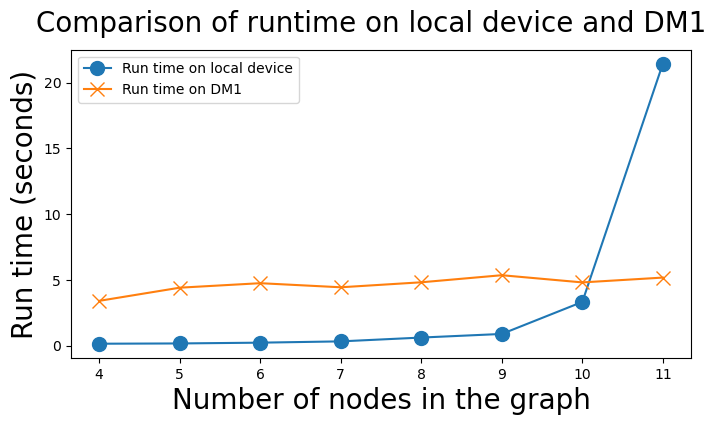

In [12]:
plt.figure(figsize=(8,4))
plt.suptitle("Comparison of runtime on local device and DM1", size=20)
plt.plot(n_nodes_list, runtimes_local, 'o-', markersize=10, label='Run time on local device')
plt.plot(n_nodes_list, runtimes_DM1, 'x-', markersize=10, label='Run time on DM1')
plt.legend()
plt.xlabel("Number of nodes in the graph", fontsize=20)
plt.ylabel("Run time (seconds)", fontsize=20)

plt.show()

When $n_\text{nodes}\leq 10$, the local device runs faster than DM1 because the execution time  of the latter is dominated by the network overhead. However, already for $n_\text{nodes}\geq11$, DM1 runs much faster and the difference will grow as $n_\text{nodes}$ gets larger. We note that the runtime on the local device will depend on the actual hardware that this notebook is running on. 

### Comparing the effect of noise channels for QAOA <a class="anchor" id="benchmark2_v2"></a>

Finally, we compare the effects of different noise channels with different noise strengths on the convergence of our algorithm. In particular, we consider the bit flip and the phase damping channels with $p\in\{0, 0.05, 0.25\}$. For simplicity, we pick the same graph and optimizer as in the noise-free QAOA example.

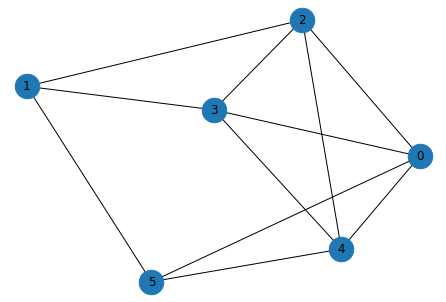

In [13]:
optimizer = qml.GradientDescentOptimizer()

n_nodes = 6
seed = 1967
g = nx.erdos_renyi_graph(n_nodes, p=0.5, seed=seed)

positions = nx.spring_layout(g, seed=seed)
nx.draw(g, with_labels=True, pos=positions, node_size=600)

plt.show()

We save the values of the cost function at each iteration step, and then sample the probability of the final outcomes.

In [14]:
def get_cost_sampling(g, n_layers, noise_opt, p, params, n_iterations, shots, dev):

    cost_func, samples = QAOA(g, n_layers, noise_opt, p, dev)

    costs = [cost_func(params)]

    for i in range(n_iterations):
        params = optimizer.step(cost_func, params)
        cost_eval = cost_func(params)
        costs.append(cost_eval)
        print(f"Completed iteration {i + 1}, cost function:", cost_eval)

    s = samples(params).T
    s = (1 - s.numpy()) / 2
    s = map(tuple, s)

    counts = Counter(s)
    indx = np.ndindex(*[2] * n_nodes)

    probs = {p: counts.get(p, 0) / shots for p in indx}

    return costs, probs

We use 4 layers for the full QAOA circuit, set the number of shots to be `shots=1000`, and fix the number of iterations to be `n_iterations=50`. Note that for fairness of the comparison, we always start with the same initial `params` for the optimization process.
<div class="alert alert-block alert-info">
<b>Note 1</b> The choice of depth, number of shots and iterations of QAOA is a tradeoff between improved solutions (for greater depth and more iterations) and longer runtime.
</div>

<div class="alert alert-block alert-info">
<b>Note 2</b> We have chosen a relatively smaller graph for illustrating the impact of noise on QAOA. As a result, the local simulator is sufficient for the task. For users who would like to try larger graphs on DM1, we recommend monitoring the Billing & Cost Management Dashboard on the AWS console and being aware that jobs involving a large number of qubits or deep circuits can be costly. 
</div>
<div class="alert alert-block alert-warning">
<b>Caution:</b> Running the following cell will take a long time. Only uncomment the cell if you are comfortable with the potential wait time.
</div>

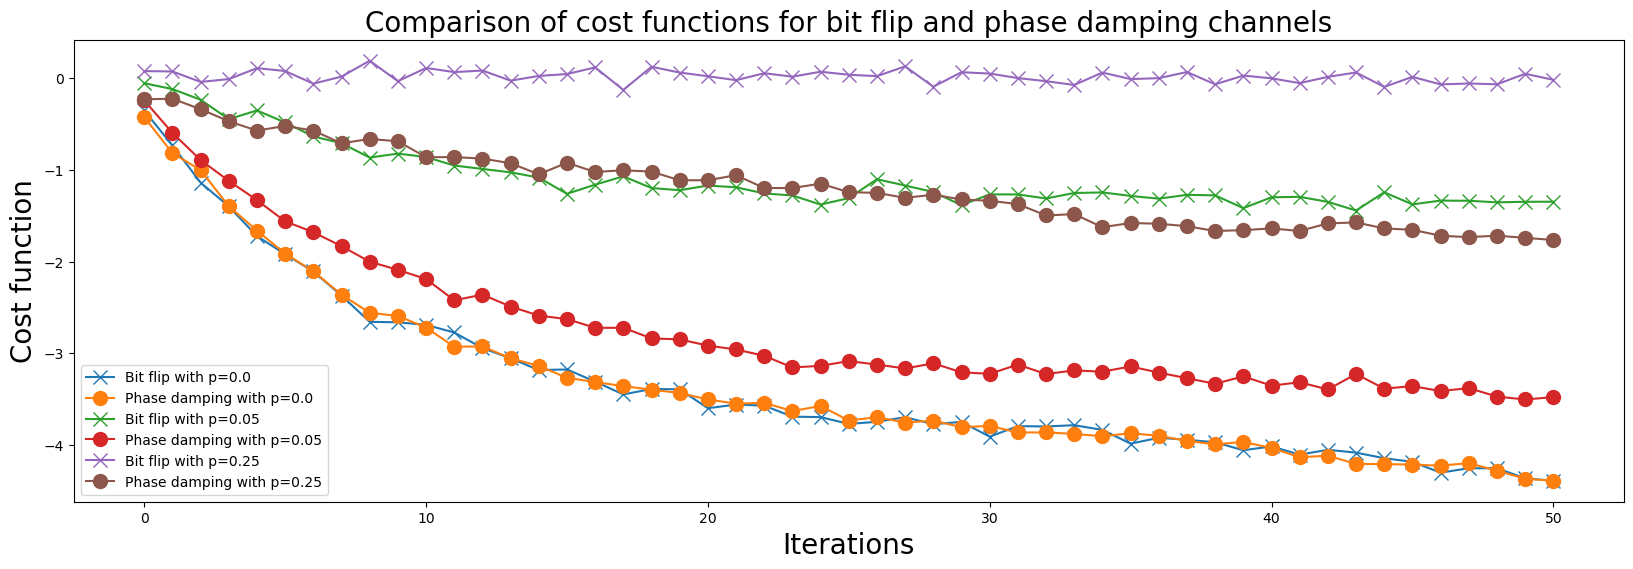

In [15]:
# ps = [0.0, 0.05, 0.25]
# noise_opts = [qml.BitFlip, qml.PhaseDamping]

# n_layers = 4
# shots = 1000
# n_iterations = 50

# params = np.random.uniform(size=[2, n_layers])

# dev = qml.device("braket.local.qubit", backend="braket_dm", wires=n_nodes, shots=shots)

# costs_range = []
# probs_range = []
# for p in ps:
#     costs_range_2 = []
#     probs_range_2 = []
#     for noise_opt in noise_opts:
#         costs, probs = get_cost_sampling(
#             g, n_layers, noise_opt, p, params, n_iterations, shots, dev
#         )
#         costs_range_2.append(costs)
#         probs_range_2.append(probs)

#     costs_range.append(costs_range_2)
#     probs_range.append(probs_range_2)

# ## Plot the results

# plt.figure(figsize=(20, 6))
# for i in range(len(ps)):
#     for j in range(len(noise_opts)):
#         if j == 0:
#             label = f"Bit flip with p={ps[i]}"
#             marker = "x-"
#         elif j == 1:
#             label = f"Phase damping with p={ps[i]}"
#             marker = "o-"

#         plt.plot(costs_range[i][j], marker, markersize=10, label=label)

# plt.legend()
# plt.xlabel("Iterations", fontsize=20)
# plt.ylabel("Cost function", fontsize=20)
# plt.title(
#     "Comparison of cost functions for bit flip and phase damping channels", size=20
# )
# plt.show()

# fig, axs = plt.subplots(len(ps), 2, figsize=(20, 8))
# fig.suptitle(
#     "Comparison of probability distributions for bit flip and phase damping channels",
#     size=20,
# )
# axs[0][0].set_title("BitFlip", fontsize=20)
# axs[0][1].set_title("PhaseDamping", fontsize=20)
# # axs.set_ylabel('Probability')
# for ii in range(len(ps)):
#     axs[ii][0].bar(range(2 ** n_nodes), probs_range[ii][0].values())
#     axs[ii][1].bar(range(2 ** n_nodes), probs_range[ii][1].values())
#     axs[ii][0].set_ylim([0, 0.5])
#     axs[ii][1].set_ylim([0, 0.5])
#     textstr = "".join(("p=", str(ps[ii])))
#     axs[ii][0].text(2 ** n_nodes / 2, 0.3, textstr, fontsize=20)
#     axs[ii][1].text(2 ** n_nodes / 2, 0.3, textstr, fontsize=20)
# axs[1][0].set_ylabel("Probability", fontsize=20)
# for ax in axs.flat:
#     ax.set_xlabel("Bit string", size=20)
# for ax in axs.flat:
#     ax.label_outer()

For the first plot, when $p=0$, both QAOA circuits reproduce the noiseless result as expected, and both cost functions nearly overlap throughout the iteration process. 
Upon increasing the noise strength, for $p=0.05$, the distinction between the two noise channels starts to appear: for the phase damping case, the cost function only deviates marginally from the noiseless case, 
whereas the cost function is halved for the bit flip case. 
The difference is even more dramatic for $p=0.25$, where the classical optimizer is incapable of optimizing the QAOA with bit flip noise, and its cost function essentially fluctuates around 0. 
On the other hand, QAOA shows remarkable robustness to phase damping noise, and the cost function converges after around $40$ iteration steps. 

This sharp distinction between bit flip and phase damping channels is also evident from the comparison of probability distributions. 
For the plots with $p=0$, the highest peaks correspond to the most frequent outcome, as represented by the bit-string `101110` (not shown in the figures), which is the maximum clique of the given graph. 
When $p=0.05$, compared to the phase damping case, the probability of the maximum clique substantially decreases for the bit flip case. 
Although we can still infer the correct solution for the bit flip case when $p=0.05$, this is no longer the case for $p=0.25$ where the noise completely destroys any useful information. Remarkably, the QAOA with phase damping can still produce the correct result but less reliably, and we expect that QAOA with phase damping channel will fail for even larger $p$.

To summarize, there are a few takeaways from the above comparison.
1. For QAOA with a given type of noise channel, the approximate solution gets less reliable with increasing noise strength, as expected;

2. For a given noise strength, different noise channels can have very different effects;

3. QAOA is robust to certain types of noise: for certain noise channels, QAOA can provide reliable solutions for graph-based optimization problems, even with moderate noise strength. However, detailed exploration of this topic is beyond the scope of this notebook.

In [16]:
print("Task Summary")
print(t.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.3f} USD")

Task Summary
{'arn:aws:braket:::device/quantum-simulator/amazon/dm1': {'shots': 40000, 'tasks': {'COMPLETED': 8}, 'execution_duration': datetime.timedelta(seconds=1, microseconds=158000), 'billed_execution_duration': datetime.timedelta(seconds=24)}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 0.030 USD
